"_Topics are distributions of words_"</br>
"_Documents are distributions of topics_"</br>

Usefule resources:</br>
[topic modeling with scikit learn](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)</br>
[visualizing](https://github.com/parulsethi/gensim/blob/tensorboard_logs/docs/notebooks/Training_visualizations.ipynb) lda training process</br>
nice [visualizations](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) of topics, words and documents</br>
topic models [correlations](https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html#sphx-glr-auto-examples-howtos-run-compare-lda-py)
</br>

TODO: </br>
topic modeling use cases</br>
dendogram</br>

## Setup

In [1]:
# &> /dev/null - hides output
!pip install spacy &> /dev/null
!pip install pyLDAvis==2.1.2 &> /dev/null
!python -m spacy download en_core_web_md &> /dev/null
!python -m spacy download en &> /dev/null
!pip install tmtoolkit &> /dev/null
!python -m pip uninstall matplotliby &> /dev/null
!pip install matplotlib==3.1.3 &> /dev/null

Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import re
from pprint import pprint
from tqdm import tqdm
from IPython.core.display import HTML

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


Settings

In [3]:
use_sub_categories = True
categories = ['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']
RANDOM_STATE = 42

Load dataset

In [4]:
newsgroups_train_cleaned = fetch_20newsgroups(subset='train', 
                                              remove=('headers', 'footers', 'quotes'), 
                                              categories = categories if use_sub_categories else None,
                                              shuffle=True, 
                                              random_state=RANDOM_STATE)

X = newsgroups_train_cleaned.data
y = newsgroups_train_cleaned.target
target_names = newsgroups_train_cleaned.target_names

## Prepare data

In [5]:
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [6]:
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.sub('\d', '', text)  # remove numbers 
    text = ' '.join(text.split())  # replace whitespace with single space

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token for token in tokens if len(token) > 1]

    return ' '.join(tokens)

<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<input>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-6-38f9670eaead>:4: DeprecationWarning: invalid escape sequence \d
  text = re.sub('\d', '', text)  # remove numbers


In [7]:
X_clean = [preprocess(doc) for doc in tqdm(X)]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
 44%|████▎     | 969/2218 [00:21<00:29, 41.82it/s]/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-p

Let's fit vectorizer with preprocessed data

In [8]:
vectorizer = CountVectorizer(max_df=0.95, 
                             min_df=2,
                             max_features=1000)

tf = vectorizer.fit_transform(X_clean)
vocabulary = vectorizer.get_feature_names()

## Scikit-learn topic modeling with LDA

### Find best number of topics

Default evaluation metric is log likelihood</br>
More on evaluation metrics for topic modeling [here](https://towardsdatascience.com/topic-model-evaluation-3c43e2308526)

In [9]:
def get_lda_model(n_topics=10):  # this is default value
    return LatentDirichletAllocation(n_components=n_topics,
                                     max_iter=5,
                                     learning_method='online',
                                     learning_offset=50.,
                                     random_state=RANDOM_STATE)

#### Grid search

In [10]:
search_params = {'n_components': [2, 3, 4, 5]}

model = get_lda_model()  
grid_search = GridSearchCV(model, param_grid=search_params, n_jobs=-1)

grid_search.fit(tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

In [11]:
best_model = grid_search.best_estimator_
print(best_model)

best_params = grid_search.best_params_
print(best_params)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
{'n_components': 3}


Compare models - higher is better

In [12]:
scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for i in range(len(params)):
    print(params[i], '  ',  'Log likelihood:', scores[i])

{'n_components': 2}    Log likelihood: -175427.75203256155
{'n_components': 3}    Log likelihood: -174905.94256487157
{'n_components': 4}    Log likelihood: -176359.1773899818
{'n_components': 5}    Log likelihood: -177474.78943107824


Show top words per topic

In [13]:
def get_top_words_per_topics(model, vocabulary, n_top_words=10):
    top_words = [] 
    for topic in model.components_:  # word distribution per topic 
        top_words.append([vocabulary[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
    
    df = pd.DataFrame(top_words)
    df.index = ["Topic " + str(i) for i in range(len(top_words))]
    df.columns = ["Word " + str(i) for i in range(len(top_words[0]))]
    return df

In [14]:
model = get_lda_model(n_topics=best_params['n_components'])
model.fit(tf)
get_top_words_per_topics(model, vocabulary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,gun,people,right,law,weapon,firearm,state,file,government,think
Topic 1,god,people,know,think,believe,say,jesus,thing,time,come
Topic 2,space,nasa,launch,system,orbit,satellite,year,earth,program,mission


Knowing target topics, we can see that two different topics are merged into one (guns and space)

#### Try different number of topics

Lets see how word distribution looks like for 4 topics

In [15]:
model = get_lda_model(n_topics=4)
model.fit(tf)
get_top_words_per_topics(model, vocabulary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,gun,people,right,law,weapon,firearm,state,file,government,think
Topic 1,god,people,know,think,believe,jesus,say,thing,come,time
Topic 2,space,earth,system,satellite,mission,nasa,orbit,information,datum,available
Topic 3,space,year,launch,nasa,like,edu,post,cost,know,time


Hmmm... it is questionable whether model suceed to successfully separate atheism and christian topics</br>
Lets visualize

In [16]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, tf, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      269.562408 -124.803398       1        1  47.098016
0        1.782994 -295.079681       2        1  24.495989
3      220.811432 -343.832123       3        1  16.536752
2       50.533993  -76.050934       4        1  11.869243, topic_info=         Term         Freq        Total Category  logprob  loglift
846     space   986.000000   986.000000  Default  30.0000  30.0000
377       gun   879.000000   879.000000  Default  29.0000  29.0000
365       god  1553.000000  1553.000000  Default  28.0000  28.0000
564      nasa   397.000000   397.000000  Default  27.0000  27.0000
471    launch   357.000000   357.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
791   science    93.887714   225.813331   Topic4  -5.1160   1.2536
844    source    87.040636   197.793890   Topic4  -5.1917   1.3104
799   section    75.785571   114.490639   Topic4  -5.3302   1.7186
471    launch    88.348971   357.679636   Topic4  -5.1768   0.7329
566  national    77.394121   191.733728   Topic4  -5.3092   1.2240

[258 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
28        1  0.009535  amendment
28        2  0.982086  amendment
28        3  0.009535  amendment
28        4  0.009535  amendment
36        2  0.037859  anonymous
...     ...       ...        ...
992       1  0.994169    worship
996       1  0.216540       year
996       2  0.258602       year
996       3  0.423734       year
996       4  0.099702       year

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

Topic 2 on this visualization shows weak 'Estimated term frequency within the selected topic' compared to 'Overall term frequency'


Lets try with 3 topics

In [17]:
model = get_lda_model(n_topics=3)
model.fit(tf)
get_top_words_per_topics(model, vocabulary)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,gun,people,right,law,weapon,firearm,state,file,government,think
Topic 1,god,people,know,think,believe,say,jesus,thing,time,come
Topic 2,space,nasa,launch,system,orbit,satellite,year,earth,program,mission


In [18]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, tf, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  49.687891
0      -387.996002  -373.316162       2        1  27.067234
2     -2184.745605   -60.565800       3        1  23.244875, topic_info=        Term         Freq        Total Category  logprob  loglift
846    space   985.000000   985.000000  Default  30.0000  30.0000
377      gun   878.000000   878.000000  Default  29.0000  29.0000
365      god  1553.000000  1553.000000  Default  28.0000  28.0000
564     nasa   396.000000   396.000000  Default  27.0000  27.0000
471   launch   358.000000   358.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
791  science   136.522065   224.312853   Topic3  -5.4137   0.9625
948      use   157.166758   529.129112   Topic3  -5.2729   0.2452
920     time   171.541447   907.434446   Topic3  -5.1854  -0.2067
392     high   132.208158   254.106592   Topic3  -5.4458   0.8057
990     work   132.325972   470.010243   Topic3  -5.4450   0.1916

[212 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
28        1  0.009542  amendment
28        2  0.982795  amendment
28        3  0.009542  amendment
31        1  0.015694       ames
31        3  0.988705       ames
...     ...       ...        ...
990       3  0.280845       work
992       1  0.994662    worship
996       1  0.274267       year
996       2  0.320753       year
996       3  0.404428       year

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

Looks better now :)

Read why log likelihood and perplexity are not the best evaluation metrics for topic models [link](http://qpleple.com/perplexity-to-evaluate-topic-models/)

#### Coherence

Try **coherence** as metric instead of log likelihood.</br>
Measures:</br>
u_mass</br>
c_v - The CV metric scores range from 0 to 1 (where good topic coherence scores range between 0.5–0.65) 

In [19]:
n_topics = range(2, 30)
u_mass_values = []
cv_values = []
prepared_texts = [x.split() for x in X_clean]
vocab = np.array([x for x in vectorizer.vocabulary_.keys()])
for n_topic in tqdm(n_topics):
    model = get_lda_model(n_topics=n_topic)
    model.fit(tf)
    u_mass_val = metric_coherence_gensim(measure='u_mass',
                            top_n=25, 
                            topic_word_distrib=model.components_, 
                            dtm=tf, 
                            vocab=vocab, 
                            texts=prepared_texts,
                            return_mean=True)
    
    cv_val = metric_coherence_gensim(measure='c_v',
                        top_n=25, 
                        topic_word_distrib=model.components_, 
                        dtm=tf, 
                        vocab=vocab, 
                        texts=prepared_texts,
                        return_mean=True)
    
    u_mass_values.append(u_mass_val)
    cv_values.append(cv_val)

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
100%|██████████| 28/28 [05:25<00:00, 11.62s/it]


In [20]:
print(cv_values)
print(u_mass_values)

[0.34646447605219427, 0.3471690882483802, 0.36196547763364534, 0.33276908543391737, 0.34153726353462305, 0.33811620944782644, nan, nan, 0.3354400485339638, nan, nan, 0.31311152315497637, 0.31852836307218757, nan, nan, nan, nan, 0.325096428861041, 0.322162663347156, 0.32409414865920094, 0.3226568814351448, 0.32165483386002885, 0.3041108420980751, 0.3290754020273796, nan, nan, 0.32817217069960536, nan]
[-2.0079988487272464, -1.5092624808688562, -1.5319417126375043, -1.5052478535619531, -1.6425752979180557, -1.752050605042546, -1.8010150021446898, -1.8376306964960558, -1.8915947667523476, -2.100316819468898, -2.036984557704229, -2.2205989824487733, -2.2736508247597262, -2.08832076030625, -2.126394403319198, -2.2097841221200976, -2.1589105669615014, -2.2002843282758455, -2.3229080818030288, -2.17685337179163, -2.310926256300432, -2.208147764355449, -2.3209209150393404, -2.333963150565922, -2.069346003103924, -2.160437518564201, -2.1510016081620535, -2.297898437681702]


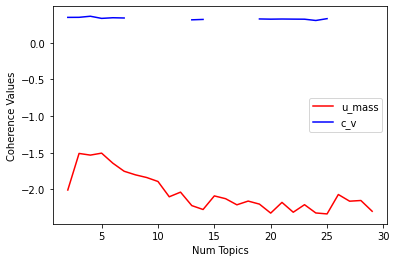

In [21]:
plt.plot(n_topics, u_mass_values, color='r', label='u_mass')
plt.plot(n_topics, cv_values, color='b', label='c_v')
plt.xlabel("Num Topics")
plt.ylabel("Coherence Values")
plt.legend()
plt.show()

Advanced [tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb) on how to find best number of topics

### Explore

Explore document topics

In [22]:
index = 102

text = X[index]
#text = X_clean[index]
print('*** Text ***')
print(text)

print('\n*** Target ***')
print(target_names[y[index]])

output = model.transform(tf[index])
print('\n*** Output ***')

for topic_idx, _ in enumerate(model.components_):
    print(f"Topic #{topic_idx}: {output[0][topic_idx]}")

*** Text ***
 >> bad people, while not interfering with good people, I think we'd all be
 >> for it.  The problem is, the methods we're using now don't do the trick.

   > Don't manufacture them.  Don't sell them.  Don't import them.
   >
   > Some guns will get through, but far fewer, and far less people will
   > die because of them.  Hunting weapons could be allowed, of course, as
   > long as they are big, and bulky, and require reloading after a few
   > shots (how many times can you shoot at the same animal, anyways One
   > assumes they are moving!)

A better solution:

*** Target ***
talk.politics.guns

*** Output ***
Topic #0: 0.001326259946951877
Topic #1: 0.0013262599469513934
Topic #2: 0.0013262599469498683
Topic #3: 0.0013262599469527775
Topic #4: 0.0013262599469497
Topic #5: 0.001326259946949759
Topic #6: 0.0013262599469503502
Topic #7: 0.1262685227134565
Topic #8: 0.0013262599469497007
Topic #9: 0.8379224587188564
Topic #10: 0.0013262599469523542
Topic #11: 0.00132625994

In [28]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

Show top documents per topic</br>

In [23]:
# word_to_topic = word to topics matrix(topics x words)
# topic_to_doc = topics to documents matrix(docs x topics)
def get_topics_per_documents(word_to_topic, topic_to_doc, no_top_documents=1):
    top_docs = []
    for topic_idx, topic in enumerate(word_to_topic):
        # give me all docs per topic, sort them by topic relevancy, reverse order, get top n doc indices ! 
        top_docs.append(np.argsort( topic_to_doc[:,topic_idx] )[::-1][0:no_top_documents])
    return top_docs

no_top_documents = 3
topic_to_doc = model.transform(tf)
top_docs_ids = get_topics_per_documents(model.components_, topic_to_doc, no_top_documents)

for i, top_docs in enumerate(top_docs_ids):
    print('\n#################')
    print(f'#### Topic {i} ####')
    print('#################\n')
    for j, doc_id in enumerate(top_docs):
        print('---------------')
        print(f'---- Doc {j} ----')
        print('---------------\n')
        print(X[doc_id][:500])
        print()


#################
#### Topic 0 ####
#################

---------------
---- Doc 0 ----
---------------


So why do I read in the papers that the Qumram texts had "different
versions" of some OT texts.   Did I misunderstand?

---------------
---- Doc 1 ----
---------------







I agree fully with the above statement and is *precisely* what I meant
by my previous statements about Islam not being anarchist and the
law not being _enforcible_ despite the _law_ being applicable. 




I disagree with this conclusion about the _applicability_ of the 
Islamic law to all muslims, wherever they may be. The above conclusion 
does not strictly follow from the foregoing, but only the conclusion 
that the fatwa cannot be *enforced* according to Islamic law. However, 
I do agre

---------------
---- Doc 2 ----
---------------






Okay... I argued this thoroughly about 3-4 weeks ago.  Men and women are
different ... physically, physiologically, and psychologically.  Much
recent evidence for this s

Topic distribution for every doc

In [24]:
df = pd.DataFrame(topic_to_doc)
df.columns = ['Topic ' + str(i) for i in range(topic_to_doc.shape[1])]
df.index = ['Doc ' + str(i) for i in range(topic_to_doc.shape[0])]

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

df.head(10).style.applymap(color_green).applymap(make_bold)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28
Doc 0,0.632290,0.001916,0.001916,0.050104,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.164941,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.001916,0.104773,0.001916,0.001916,0.001916,0.001916
Doc 1,0.000352,0.211917,0.000352,0.528130,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.197411,0.000352,0.053745,0.000352,0.000352,0.000352,0.000352
Doc 2,0.000454,0.521986,0.037906,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454,0.024030,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454,0.044791,0.000454,0.000454,0.000454,0.360397,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454
Doc 3,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.255420,0.000066,0.000066,0.000066,0.026894,0.000066,0.399979,0.000066,0.000066,0.000066,0.000066,0.030886,0.034994,0.000066,0.062632,0.187748,0.000066,0.000066,0.000066
Doc 4,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.039063,0.000285,0.953243,0.000285,0.000285
Doc 5,0.001078,0.001078,0.001078,0.001078,0.001078,0.001078,0.001078,0.049101,0.001078,0.121803,0.674062,0.001078,0.001078,0.001078,0.001078,0.001078,0.001078,0.090371,0.001078,0.001078,0.001078,0.001078,0.001078,0.038801,0.001078,0.001078,0.001078,0.001078,0.001078
Doc 6,0.001642,0.001642,0.001642,0.001642,0.001642,0.001642,0.001642,0.001642,0.001642,0.497719,0.001642,0.001642,0.001642,0.058263,0.122221,0.001642,0.001642,0.041242,0.001642,0.001642,0.001642,0.001642,0.001642,0.001642,0.241146,0.001642,0.001642,0.001642,0.001642
Doc 7,0.000396,0.000396,0.047652,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.000396,0.104199,0.179410,0.658829,0.000396,0.000396,0.000396,0.000396
Doc 8,0.017241,0.017241,0.017241,0.517241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241,0.017241
Doc 9,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.554600,0.398848,0.001724,0.001724,0.001724,0.001724,0.001724


In [25]:
df['Dominant Topic'] = df.idxmax(axis=1)
df['Dominant Topic'].value_counts()

Topic 24    463
Topic 22    411
Topic 7     227
Topic 10    198
Topic 26    155
Topic 0     118
Topic 23    107
Topic 1      94
Topic 16     86
Topic 9      77
Topic 2      57
Topic 21     43
Topic 25     33
Topic 15     33
Topic 14     30
Topic 3      28
Topic 20     26
Topic 6      14
Topic 18      7
Topic 17      4
Topic 13      3
Topic 4       2
Topic 5       1
Topic 27      1
Name: Dominant Topic, dtype: int64

Try on custom text

In [26]:
text = 'I support theory that some higher intelligence created this world'
text = preprocess(text)
term_freq = vectorizer.transform([text])

output = model.transform(term_freq)
for topic_idx, _ in enumerate(model.components_):
    print(f"Topic #{topic_idx}: {output[0][topic_idx]}")

Topic #0: 0.7222380206724703
Topic #1: 0.0057471264368009695
Topic #2: 0.005747126436787951
Topic #3: 0.12258956553411796
Topic #4: 0.005747126436782175
Topic #5: 0.005747126436782173
Topic #6: 0.005747126436782173
Topic #7: 0.005747126436808484
Topic #8: 0.005747126436782173
Topic #9: 0.005747126436851443
Topic #10: 0.0057471264368253155
Topic #11: 0.005747126436782173
Topic #12: 0.005747126436782185
Topic #13: 0.005747126436782173
Topic #14: 0.005747126436815236
Topic #15: 0.00574712643678357
Topic #16: 0.0057471264368161344
Topic #17: 0.005747126436782173
Topic #18: 0.005747126436782173
Topic #19: 0.005747126436782242
Topic #20: 0.005747126436784209
Topic #21: 0.005747126436787405
Topic #22: 0.005747126436797815
Topic #23: 0.005747126436785736
Topic #24: 0.005747126436793899
Topic #25: 0.005747126436795459
Topic #26: 0.0057471264367921155
Topic #27: 0.005747126436782173
Topic #28: 0.005747126436782194


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
